In [26]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
from scipy.interpolate import interp1d

%matplotlib inline
plt.rcParams.update({'font.size': 12})


In [37]:
def load_data(fname):
    ds = xr.open_dataset(fname)
    ds = ds.sel(Time=slice('2015-03-10', '2015-03-20'))
    df = ds.to_dataframe()
    df.reset_index(inplace=True)
    return df


def find_anomalous_values(df, column='X', std_factor=3, window=20):
    rolling_mean = df['X'].rolling(20).mean()
    rolling_std = df['X'].rolling(20).std()
    bad_values = (df['X'] < rolling_mean - std_factor * rolling_std) | (df['X'] > rolling_mean + std_factor * 
                                                                        rolling_std)
    df['bad_values'] = bad_values
    return bad_values, rolling_mean, rolling_std


def create_flag_col(df, column='X', flag_column='flag_column'):
    # Set everything to zero first
    df['flag_column'] = 0
    # Null flag is 1
    df['flag_column'][df['X'].isnull() == True] = 1
    return df


def flag_anomalies(df, flag_col='flag_column', bad_values='bad_values'):
    # set anomaly flag to 2
    df[flag_col][bad_values == True] = 2
    return df

def interpolate_values(df, column='X'):
    df['fill_column'] = df['X'].interpolate(method='cubic')
    return df

def simple_plot(df, column_x='X', column_y='Y', x_limits=[datetime.date(2015, 3, 11), datetime.date(2015, 3, 20)],
                s=0.05):
    plt.scatter(df['X'], df['Y'], s=s)
    plt.xlim(x_limits)
    plt.xticks(rotation=120)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    
def interpolation_plot(df, column_x='X', column_y='Y', flag_col='flag_column', fill_col='fill_column', 
                       x_limits=[datetime.date(2015, 3, 11), datetime.date(2015, 3, 20)]):
    plt.figure(figsize=(10, 8))
    plt.plot(df[column_x], df[column_y], label=column_y)
    plt.scatter(df[column_x][df[flag_col] == 1], df[fill_col][df[flag_col] == 1],
                label='Interpolation', color='red')
    plt.xlim(x_limits)
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.xticks(rotation=120)
    plt.legend()
    plt.show()
    
def fancy_plot(df, column_x='X', column_y='Y', flag_col='flag_column', filled_col='fill_column',
               rolling_mean=df['X'].rolling(20).mean(), rolling_std=df['X'].rolling(20).std(),
               x_limits=[datetime.date(2015, 3, 11), datetime.date(2015, 3, 20)], std_factor=3):
    fig = plt.figure(figsize=(12, 10))
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)

    ax1.plot(df[column_x], df[column_y], label=column_y, color='teal')
    ax1.plot(df[column_x], rolling_mean, color='coral', label='Rolling Mean')
    ax1.fill_between(df[column_x], rolling_mean - std_factor * rolling_std, rolling_mean + std_factor * rolling_std,
                     alpha=0.5, color='teal')
    # ax1.scatter(df[column_x][df[flag_col[column_y]] == 1], df[filled_col[column_y]][df[flag_col[column_y]] == 1],
    #          label='Interpolation', s=2)
    ax1.scatter(df[column_x][df[flag_col[column_y]] == 2], df[filled_col[column_y]][df[flag_col[column_y]] == 2],
                label='Anomalies', color='red', marker='x')

    ax2.plot(df[column_x], rolling_std, color='orange', label='Rolling Standard Deviation')

    ax1.get_shared_x_axes().join(ax1, ax2)
    ax1.set_xticklabels([])

    plt.xlim(x_limits)
    plt.xlabel(column_x)
    plt.xticks(rotation=90)
    ax1.legend()
    ax2.legend()
    plt.show()

In [38]:
filename = '/Users/gabriel/Desktop/DATA-LASP/cmo_dmin.nc'
df = load_data(filename)


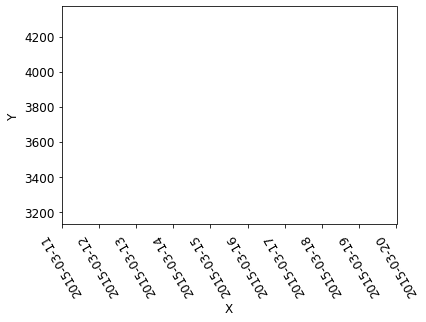

In [39]:
simple_plot(df)